# Generating trading signals with LightGBM

## Imports & Settings

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
#!pip install lightgbm==3.3.2
#!pip install catboost==1.0.5

In [3]:
%matplotlib inline

from pathlib import Path
import sys, os
from time import time
from collections import defaultdict
from itertools import product

import numpy as np
import pandas as pd

import lightgbm as lgb
from catboost import Pool, CatBoostRegressor

from sklearn.linear_model import LinearRegression
from scipy.stats import spearmanr

from alphalens.tears import (create_summary_tear_sheet,
                             create_full_tear_sheet)

from alphalens.utils import get_clean_factor_and_forward_returns

import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
np.random.seed(42)

In [5]:
sys.path.insert(1, os.path.join(sys.path[0], '..'))
from utils import MultipleTimeSeriesCV, format_time

In [6]:
sns.set_style('whitegrid')

## Algunas declaraciones iniciales

In [7]:
#decimos si queremos datos semanales o no
datos_semanales=1

In [8]:
#YEAR = 252
YEAR = 12
if datos_semanales==1:
    YEAR=52

idx = pd.IndexSlice

In [9]:
#si queremos borrar los datos anteriores, si no, poner borrado = False
borrado=True

## Get Data (for train & validation period)

We select the train and validation sets, and identify labels and features:

In [10]:
DATA_STORE = 'data/assets.parquet'


In [11]:
data = pd.read_parquet('data/data.parquet')
print(data.columns)
data.head()

Index(['return_01w', 'return_02w', 'return_03w', 'return_06w', 'return_12w',
       'return_52w', 'Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'momentum_02',
       'momentum_03', 'momentum_06', 'momentum_12', 'momentum_52',
       'momentum_3_12', 'month', 'sector', 'return_01w_t-1', 'return_01w_t-2',
       'return_01w_t-3', 'return_01w_t-4', 'return_01w_t-5', 'return_01w_t-6',
       'target_01w', 'target_02w', 'target_03w', 'target_06w', 'target_12w',
       'recession', 'yield_curve', 'corp_oas', 'hy_oas', 'eu_hy_oas',
       'sentiment', 'real_gdp', 'oil', 'inflacion', 'leading', 'vix', 'vixoil',
       'weekjobclaims', 'retail_sales_percent', 'retail_sales', '1y_yield',
       'recession_diff', 'yield_curve_diff', 'corp_oas_diff', 'hy_oas_diff',
       'eu_hy_oas_diff', 'sentiment_diff', 'empleo_diff', 'real_gdp_diff',
       'oil_diff', 'inflacion_diff', 'leading_diff', 'vix_diff', 'vixoil_diff',
       'weekjobclaims_diff', 'retail_sales_percent_diff', 'retail_sales_diff',
       'us

return_01w  return_02w  return_03w  \
ticker date                                                            
IYR    2005-01-02 00:00:00+00:00         NaN         NaN         NaN   
       2005-01-09 00:00:00+00:00         NaN         NaN         NaN   
       2005-01-16 00:00:00+00:00         NaN         NaN         NaN   
       2005-01-23 00:00:00+00:00         NaN         NaN         NaN   
       2005-01-30 00:00:00+00:00         NaN         NaN         NaN   

                                  return_06w  return_12w  return_52w  \
ticker date                                                            
IYR    2005-01-02 00:00:00+00:00         NaN         NaN         NaN   
       2005-01-09 00:00:00+00:00         NaN         NaN         NaN   
       2005-01-16 00:00:00+00:00         NaN         NaN         NaN   
       2005-01-23 00:00:00+00:00         NaN         NaN         NaN   
       2005-01-30 00:00:00+00:00         NaN         NaN         NaN   

                                    Mkt-RF       SMB      HML      RMW  ...  \
ticker date                                                             ...   
IYR    2005-01-02 00:00:00+00:00  0.100716  0.041236  0.02016 -0.04512  ...   
       2005-01-09 00:00:00+00:00  0.100716  0.041236  0.02016 -0.04512  ...   
       2005-01-16 00:00:00+00:00  0.100716  0.041236  0.02016 -0.04512  ...   
       2005-01-23 00:00:00+00:00  0.100716  0.041236  0.02016 -0.04512  ...   
       2005-01-30 00:00:00+00:00  0.100716  0.041236  0.02016 -0.04512  ...   

                                  oil_diff  inflacion_diff  leading_diff  \
ticker date                                                                
IYR    2005-01-02 00:00:00+00:00       NaN             NaN           NaN   
       2005-01-09 00:00:00+00:00       NaN             NaN           NaN   
       2005-01-16 00:00:00+00:00       NaN             NaN           NaN   
       2005-01-23 00:00:00+00:00       NaN             NaN           NaN   
       2005-01-30 00:00:00+00:00       NaN             NaN           NaN   

                                  vix_diff  vixoil_diff  weekjobclaims_diff  \
ticker date                                                                   
IYR    2005-01-02 00:00:00+00:00       NaN          NaN                 NaN   
       2005-01-09 00:00:00+00:00       NaN          NaN                 NaN   
       2005-01-16 00:00:00+00:00       NaN          NaN                 NaN   
       2005-01-23 00:00:00+00:00       NaN          NaN                 NaN   
       2005-01-30 00:00:00+00:00       NaN          NaN                 NaN   

                                  retail_sales_percent_diff  \
ticker date                                                   
IYR    2005-01-02 00:00:00+00:00                        NaN   
       2005-01-09 00:00:00+00:00                        NaN   
       2005-01-16 00:00:00+00:00                        NaN   
       2005-01-23 00:00:00+00:00                        NaN   
       2005-01-30 00:00:00+00:00                        NaN   

                                  retail_sales_diff us_asset_balance_diff  \
ticker date                                                                 
IYR    2005-01-02 00:00:00+00:00                NaN                   NaN   
       2005-01-09 00:00:00+00:00                NaN                   NaN   
       2005-01-16 00:00:00+00:00                NaN                   NaN   
       2005-01-23 00:00:00+00:00                NaN                   NaN   
       2005-01-30 00:00:00+00:00                NaN                   NaN   

                                  1y_yield_diff  
ticker date                                      
IYR    2005-01-02 00:00:00+00:00            NaN  
       2005-01-09 00:00:00+00:00            NaN  
       2005-01-16 00:00:00+00:00            NaN  
       2005-01-23 00:00:00+00:00            NaN  
       2005-01-30 00:00:00+00:00            NaN  

[5 rows x 64 columns]

In [12]:
results_path = Path('results', 'us_stocks')

if not results_path.exists():
    results_path.mkdir(parents=True)

In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 11368 entries, ('IYR', Timestamp('2005-01-02 00:00:00+0000', tz='UTC')) to ('XLY', Timestamp('2024-11-10 00:00:00+0000', tz='UTC'))
Data columns (total 64 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   return_01w                 10796 non-null  float64
 1   return_02w                 10796 non-null  float64
 2   return_03w                 10796 non-null  float64
 3   return_06w                 10796 non-null  float64
 4   return_12w                 10796 non-null  float64
 5   return_52w                 10796 non-null  float64
 6   Mkt-RF                     11368 non-null  float64
 7   SMB                        11368 non-null  float64
 8   HML                        11368 non-null  float64
 9   RMW                        11368 non-null  float64
 10  CMA                        11368 non-null  float64
 11  momentum_02                10796 non-null  float64
 

In [14]:
data.head(50)

return_01w  return_02w  return_03w  \
ticker date                                                            
IYR    2005-01-02 00:00:00+00:00         NaN         NaN         NaN   
       2005-01-09 00:00:00+00:00         NaN         NaN         NaN   
       2005-01-16 00:00:00+00:00         NaN         NaN         NaN   
       2005-01-23 00:00:00+00:00         NaN         NaN         NaN   
       2005-01-30 00:00:00+00:00         NaN         NaN         NaN   
       2005-02-06 00:00:00+00:00         NaN         NaN         NaN   
       2005-02-13 00:00:00+00:00         NaN         NaN         NaN   
       2005-02-20 00:00:00+00:00         NaN         NaN         NaN   
       2005-02-27 00:00:00+00:00         NaN         NaN         NaN   
       2005-03-06 00:00:00+00:00         NaN         NaN         NaN   
       2005-03-13 00:00:00+00:00         NaN         NaN         NaN   
       2005-03-20 00:00:00+00:00         NaN         NaN         NaN   
       2005-03-27 00:00:00+00:00         NaN         NaN         NaN   
       2005-04-03 00:00:00+00:00         NaN         NaN         NaN   
       2005-04-10 00:00:00+00:00         NaN         NaN         NaN   
       2005-04-17 00:00:00+00:00         NaN         NaN         NaN   
       2005-04-24 00:00:00+00:00         NaN         NaN         NaN   
       2005-05-01 00:00:00+00:00         NaN         NaN         NaN   
       2005-05-08 00:00:00+00:00         NaN         NaN         NaN   
       2005-05-15 00:00:00+00:00         NaN         NaN         NaN   
       2005-05-22 00:00:00+00:00         NaN         NaN         NaN   
       2005-05-29 00:00:00+00:00         NaN         NaN         NaN   
       2005-06-05 00:00:00+00:00         NaN         NaN         NaN   
       2005-06-12 00:00:00+00:00         NaN         NaN         NaN   
       2005-06-19 00:00:00+00:00         NaN         NaN         NaN   
       2005-06-26 00:00:00+00:00         NaN         NaN         NaN   
       2005-07-03 00:00:00+00:00         NaN         NaN         NaN   
       2005-07-10 00:00:00+00:00         NaN         NaN         NaN   
       2005-07-17 00:00:00+00:00         NaN         NaN         NaN   
       2005-07-24 00:00:00+00:00         NaN         NaN         NaN   
       2005-07-31 00:00:00+00:00         NaN         NaN         NaN   
       2005-08-07 00:00:00+00:00         NaN         NaN         NaN   
       2005-08-14 00:00:00+00:00         NaN         NaN         NaN   
       2005-08-21 00:00:00+00:00         NaN         NaN         NaN   
       2005-08-28 00:00:00+00:00         NaN         NaN         NaN   
       2005-09-04 00:00:00+00:00         NaN         NaN         NaN   
       2005-09-11 00:00:00+00:00         NaN         NaN         NaN   
       2005-09-18 00:00:00+00:00         NaN         NaN         NaN   
       2005-09-25 00:00:00+00:00         NaN         NaN         NaN   
       2005-10-02 00:00:00+00:00         NaN         NaN         NaN   
       2005-10-09 00:00:00+00:00         NaN         NaN         NaN   
       2005-10-16 00:00:00+00:00         NaN         NaN         NaN   
       2005-10-23 00:00:00+00:00         NaN         NaN         NaN   
       2005-10-30 00:00:00+00:00         NaN         NaN         NaN   
       2005-11-06 00:00:00+00:00         NaN         NaN         NaN   
       2005-11-13 00:00:00+00:00         NaN         NaN         NaN   
       2005-11-20 00:00:00+00:00         NaN         NaN         NaN   
       2005-11-27 00:00:00+00:00         NaN         NaN         NaN   
       2005-12-04 00:00:00+00:00         NaN         NaN         NaN   
       2005-12-11 00:00:00+00:00         NaN         NaN         NaN   

                                  return_06w  return_12w  return_52w  \
ticker date                                                            
IYR    2005-01-02 00:00:00+00:00         NaN         NaN         NaN   
       2005-01-09 00:00:00+00:00         NaN         NaN         NaN   
 

In [15]:
"""#modificado del original
data = (pd.read_hdf('data.h5', 'model_data')
            .sort_index()
            .loc[idx[:, :'2016'], :])
data.info(null_counts=True)"""

"#modificado del original\ndata = (pd.read_hdf('data.h5', 'model_data')\n            .sort_index()\n            .loc[idx[:, :'2016'], :])\ndata.info(null_counts=True)"

In [16]:
#labels = sorted(data.filter(like='_fwd').columns)
labels = sorted(data.filter(like='target_').columns)
features = data.columns.difference(labels).tolist()
label = 'target_01w'#modificado

## Model Selection: Lookback, lookahead and roll-forward periods

In [17]:
# Obtener el nombre del primer nivel
level_name = data.index.get_level_values(0).name
level_name

'ticker'

In [18]:
tickers = data.index.get_level_values('ticker').unique()

In [19]:
tickers

Index(['IYR', 'VOX', 'XLB', 'XLE', 'XLF', 'XLI', 'XLK', 'XLP', 'XLU', 'XLV',
       'XLY'],
      dtype='object', name='ticker')

In [20]:
#lookaheads = [1, 5, 21]
lookaheads = [1]

In [21]:
#categoricals = ['year', 'month', 'sector', 'weekda]
categoricals = [ 'month','sector']

We select 4.5 and one years as the length of our training periods; test periods are one and three months long. Since we are using 6 years (2012/18) for validation, a one-month test period implies 12x6 folds

In [22]:
#tenemos semanas 
#train_lengths = [int(4.5 * 12), 36,12]
train_lengths = [int(4.5 * 12 *4), 52]#4 años y medio año
test_lengths = [52]

In [23]:
test_params = list(product(lookaheads, train_lengths, test_lengths))

In [24]:
test_params

[(1, 216, 52), (1, 52, 52)]

## Baseline: Linear Regression

In [25]:
#cambiamos a 6 años en vez de 2 para la validación

In [26]:
years_val=6

In [27]:
#stop

In [28]:
lr = LinearRegression()

lr_metrics = []
for lookahead, train_length, test_length in test_params:
    print(lookahead, train_length, test_length)
    #label = f'r{lookahead:02}_fwd'
    label = f'target_{lookahead:02}w'
    
    df = pd.get_dummies(data.loc[:, features + [label]].dropna(), 
                        columns=categoricals, 
                        drop_first=True)
    X, y = df.drop(label, axis=1), df[label]

    n_splits = int( YEAR * years_val / test_length)# modificado#cambiamos a 6 años en vez de 2 para la validación
    cv = MultipleTimeSeriesCV(n_splits=n_splits,
                              test_period_length=test_length,
                              lookahead=lookahead,
                              train_period_length=train_length)

    ic, preds = [], []
    for i, (train_idx, test_idx) in enumerate(cv.split(X=X)):
        
        X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
        X_test, y_test = X.iloc[test_idx], y.iloc[test_idx]
        lr.fit(X_train, y_train)
        y_pred = lr.predict(X_test)
        preds.append(y_test.to_frame('y_true').assign(y_pred=y_pred))
        ic.append(spearmanr(y_test, y_pred)[0])
    preds = pd.concat(preds)
    lr_metrics.append([
        lookahead, train_length, test_length,
        np.mean(ic),
        spearmanr(preds.y_true, preds.y_pred)[0]
    ])

columns = ['lookahead', 'train_length', 'test_length', 'ic_by_day', 'ic']
lr_metrics = pd.DataFrame(lr_metrics, columns=columns)

1 216 52
1 52 52


In [29]:
n_splits

6

In [30]:
#train_idx[-2:]

In [31]:
# y.iloc[train_idx].loc['XLU.US'].index


In [32]:
#y.iloc[test_idx].loc['XLU.US'].index

In [33]:
#y_test

In [34]:
 #test_length

### Information Coefficient - Distribution by Lookahead

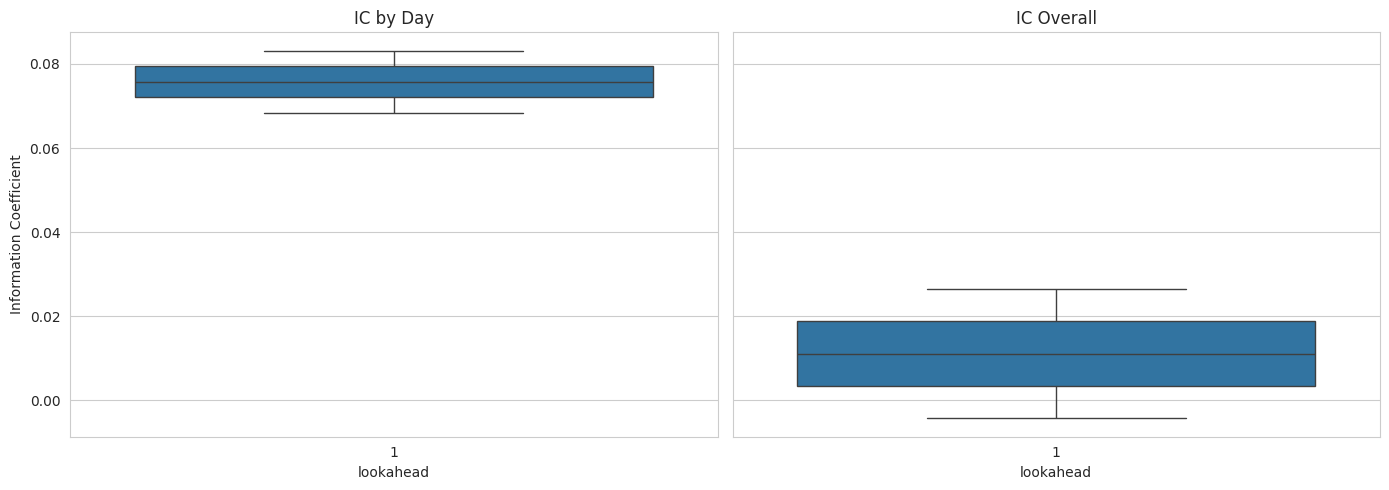

In [35]:
fig, axes =plt.subplots(ncols=2, figsize=(14,5), sharey=True)
sns.boxplot(x='lookahead', y='ic_by_day',data=lr_metrics, ax=axes[0])
axes[0].set_title('IC by Day')
sns.boxplot(x='lookahead', y='ic',data=lr_metrics, ax=axes[1])
axes[1].set_title('IC Overall')
axes[0].set_ylabel('Information Coefficient')
axes[1].set_ylabel('')
fig.tight_layout()

### Best Train/Test Period Lengths

In [36]:
(lr_metrics.groupby('lookahead', group_keys=False)
 .apply(lambda x: x.nlargest(3, 'ic_by_day')))

,lookahead,train_length,test_length,ic_by_day,ic
1,1,52,52,0.083129,-0.004243
0,1,216,52,0.068319,0.026577


In [37]:
lr_metrics.to_csv(results_path / 'lin_reg_metrics.csv', index=False)

## LightGBM Model Tuning

The notebook example iterates over many configurations, optionally using random samples to speed up model selection using a diverse subset. The goal is to identify the most impactful parameters without trying every possible combination.

In [38]:
def get_fi(model):
    fi = model.feature_importance(importance_type='gain')
    return (pd.Series(fi / fi.sum(),
                      index=model.feature_name()))

### Hyperparameter Options

The base_params are not affected by cross-validation:

In [39]:
base_params = dict(boosting='gbdt',
                   objective='regression',
                   verbose=-1)

We choose the following parameters and values to select our best model (see book chapter for detail):

In [40]:
# weight of each new tree in the ensemble
learning_rate_ops = [.01, .1, .3]
# constraints on structure (depth) of each tree
max_depths = [2, 3, 5, 7]
num_leaves_opts = [2 ** i for i in max_depths]
#min_data_in_leaf_opts = [250, 500, 1000]
min_data_in_leaf_opts = [int(250/22), int(500/22), int(1000/22)]
if datos_semanales==1: min_data_in_leaf_opts = [int(250/5), int(500/5), int(1000/5)]
# random feature selection
feature_fraction_opts = [.3, .6, .95]


In [41]:
min_data_in_leaf_opts

[50, 100, 200]

In [42]:
param_names = ['learning_rate', 'num_leaves',
               'feature_fraction', 'min_data_in_leaf']

In [43]:
cv_params = list(product(learning_rate_ops,
                         num_leaves_opts,
                         feature_fraction_opts,
                         min_data_in_leaf_opts))
n_params = len(cv_params)
print(f'# Parameters: {n_params}')

# Parameters: 108


### Train/Test Period Lengths

In [44]:
#lookaheads = [1, 5, 21]
#lookaheads = [1]
#lookaheads = [1, 2]
#label_dict = dict(zip(lookaheads, labels))

In [45]:
#train_lengths = [int(4.5 * 252), 252]
#test_lengths = [63]
#train_lengths = [int(4.5 * 12), 12]
#train_lengths = [int(4.5 * 12), 36, 12]
#test_lengths = [1,3,6]
#test_lengths = [1,3,6]

In [46]:
train_lengths

[216, 52]

In [47]:
lookaheads

[1]

In [48]:
test_params = list(product(lookaheads, train_lengths, test_lengths))
n = len(test_params)
test_param_sample = np.random.choice(list(range(n)), size=int(n), replace=False)
test_params = [test_params[i] for i in test_param_sample]
print('Train configs:', len(test_params))

Train configs: 2


In [49]:
test_params

[(1, 52, 52), (1, 216, 52)]

### Categorical Variables

In [50]:
#categoricals = ['year', 'weekday', 'month']
categoricals = ['month','sector']
for feature in categoricals:
    data[feature] = pd.factorize(data[feature], sort=True)[0]

### Custom Loss Function: Information Coefficient

In [51]:
def ic_lgbm(preds, train_data):
    """Custom IC eval metric for lightgbm"""
    is_higher_better = True
    return 'ic', spearmanr(preds, train_data.get_label())[0], is_higher_better

### Run Cross-Validation

In [52]:
borrado=True

In [53]:
#primero borramos 'tuning_lgb.h5' para que no sobrescriba parcialmente
#si queremos borrar los datos anteriores, si no, poner borrado = False
if borrado==True:
    lgb_store = Path(results_path / 'tuning_lgb.parquet')
    
    # Comprueba si el archivo existe
    if lgb_store.exists():
        # Elimina el archivo
        os.remove(lgb_store)
        print(f"El archivo {lgb_store} ha sido eliminado.")
    else:
        print(f"No se encontró el archivo {lgb_store}.")

No se encontró el archivo results/us_stocks/tuning_lgb.parquet.


In [54]:
lgb_store = Path(results_path / 'tuning_lgb.parquet')


In [55]:
labels = sorted(data.filter(like='target').columns)
features = data.columns.difference(labels).tolist()

In [56]:
labels

['target_01w', 'target_02w', 'target_03w', 'target_06w', 'target_12w']

In [57]:
features

['1y_yield',
 '1y_yield_diff',
 'CMA',
 'HML',
 'Mkt-RF',
 'RMW',
 'SMB',
 'corp_oas',
 'corp_oas_diff',
 'empleo_diff',
 'eu_hy_oas',
 'eu_hy_oas_diff',
 'hy_oas',
 'hy_oas_diff',
 'inflacion',
 'inflacion_diff',
 'leading',
 'leading_diff',
 'momentum_02',
 'momentum_03',
 'momentum_06',
 'momentum_12',
 'momentum_3_12',
 'momentum_52',
 'month',
 'oil',
 'oil_diff',
 'real_gdp',
 'real_gdp_diff',
 'recession',
 'recession_diff',
 'retail_sales',
 'retail_sales_diff',
 'retail_sales_percent',
 'retail_sales_percent_diff',
 'return_01w',
 'return_01w_t-1',
 'return_01w_t-2',
 'return_01w_t-3',
 'return_01w_t-4',
 'return_01w_t-5',
 'return_01w_t-6',
 'return_02w',
 'return_03w',
 'return_06w',
 'return_12w',
 'return_52w',
 'sector',
 'sentiment',
 'sentiment_diff',
 'us_asset_balance_diff',
 'vix',
 'vix_diff',
 'vixoil',
 'vixoil_diff',
 'weekjobclaims',
 'weekjobclaims_diff',
 'yield_curve',
 'yield_curve_diff']

In [58]:
#label_dict = dict(zip(lookaheads, labels))

In [59]:
#label_dict

In [60]:
#num_iterations = [10, 25, 50, 75] + list(range(100, 501, 50))
num_iterations = [50, 100] #+ list(range(100, 501, 50))
num_boost_round = num_iterations[-1]

In [61]:
num_iterations

[50, 100]

In [62]:
num_boost_round

100

In [63]:
metric_cols = (param_names + ['t', 'daily_ic_mean', 'daily_ic_mean_n',
                              'daily_ic_median', 'daily_ic_median_n'] +
               [str(n) for n in num_iterations])

In [64]:
metric_cols

['learning_rate',
 'num_leaves',
 'feature_fraction',
 'min_data_in_leaf',
 't',
 'daily_ic_mean',
 'daily_ic_mean_n',
 'daily_ic_median',
 'daily_ic_median_n',
 '50',
 '100']

In [65]:
YEAR

52

In [66]:
#stop

In [67]:
n_params

108

We iterate over our six CV configurations and collect the resulting metrics:

In [68]:
for lookahead, train_length, test_length in test_params:
    # randomized grid search
    cvp = np.random.choice(list(range(n_params)),
                           size=int(n_params / 2),
                           replace=False)
    cv_params_ = [cv_params[i] for i in cvp]

    # set up cross-validatio. years_val serán los años de validación
    n_splits = int(YEAR * years_val/ test_length)#modificado
    print(f'Lookahead: {lookahead:2.0f} | '
          f'Train: {train_length:3.0f} | '
          f'Test: {test_length:2.0f} | '
          f'Params: {len(cv_params_):3.0f} | '
          f'Train configs: {len(test_params)}')

    # time-series cross-validation
    cv = MultipleTimeSeriesCV(n_splits=n_splits,
                              lookahead=lookahead,
                              test_period_length=test_length,
                              train_period_length=train_length)

    #label = label_dict[lookahead] modificado para no liar
    label = label 
    outcome_data = data.loc[:, features + [label]].dropna()
    
    # binary dataset
    lgb_data = lgb.Dataset(data=outcome_data.drop(label, axis=1),
                           label=outcome_data[label],
                           categorical_feature=categoricals,
                           free_raw_data=False)
    T = 0
    predictions, metrics, feature_importance, daily_ic = [], [], [], []
    
    # iterate over (shuffled) hyperparameter combinations
    for p, param_vals in enumerate(cv_params_):
        key = f'{lookahead}/{train_length}/{test_length}/' + '/'.join([str(p) for p in param_vals])
        params = dict(zip(param_names, param_vals))
        params.update(base_params)

        start = time()
        cv_preds, nrounds = [], []
        ic_cv = defaultdict(list)
        
        # iterate over folds
        for i, (train_idx, test_idx) in enumerate(cv.split(X=outcome_data)):
            
            # select train subset
            lgb_train = lgb_data.subset(used_indices=train_idx.tolist(),
                                       params=params).construct()
            
            # train model for num_boost_round
            model = lgb.train(params=params,
                              train_set=lgb_train,
                              num_boost_round=num_boost_round,
                              )
            # log feature importance
            if i == 0:
                fi = get_fi(model).to_frame()
            else:
                fi[i] = get_fi(model)

            # capture predictions
            test_set = outcome_data.iloc[test_idx, :]
            X_test = test_set.loc[:, model.feature_name()]
            y_test = test_set.loc[:, label]
            y_pred = {str(n): model.predict(X_test, num_iteration=n) for n in num_iterations}
            
            # record predictions for each fold
            cv_preds.append(y_test.to_frame('y_test').assign(**y_pred).assign(i=i))
        
        # combine fold results
        cv_preds = pd.concat(cv_preds).assign(**params)
        predictions.append(cv_preds)
        
        # compute IC per day
        by_day = cv_preds.groupby(level='date')
        ic_by_day = pd.concat([by_day.apply(lambda x: spearmanr(x.y_test, x[str(n)])[0]).to_frame(n)
                               for n in num_iterations], axis=1)
        daily_ic_mean = ic_by_day.mean()
        daily_ic_mean_n = daily_ic_mean.idxmax()
        daily_ic_median = ic_by_day.median()
        daily_ic_median_n = daily_ic_median.idxmax()
        
        # compute IC across all predictions
        ic = [spearmanr(cv_preds.y_test, cv_preds[str(n)])[0] for n in num_iterations]
        t = time() - start
        T += t
        
        # collect metrics
        metrics = pd.Series(list(param_vals) +
                            [t, daily_ic_mean.max(), daily_ic_mean_n, daily_ic_median.max(), daily_ic_median_n] + ic,
                            index=metric_cols)
        msg = f'\t{p:3.0f} | {format_time(T)} ({t:3.0f}) | {params["learning_rate"]:5.2f} | '
        msg += f'{params["num_leaves"]:3.0f} | {params["feature_fraction"]:3.0%} | {params["min_data_in_leaf"]:4.0f} | '
        msg += f' {max(ic):6.2%} | {ic_by_day.mean().max(): 6.2%} | {daily_ic_mean_n: 4.0f} | {ic_by_day.median().max(): 6.2%} | {daily_ic_median_n: 4.0f}'
        print(msg)

        # persist results for given CV run and hyperparameter combination
        os.makedirs(os.path.dirname(str(lgb_store).replace('.parquet', '') + '_metrics/' + key.replace("/","_") ), exist_ok=True)
        os.makedirs(os.path.dirname(str(lgb_store).replace('.parquet', '') + '_daily_ic/' + key.replace("/","_") ), exist_ok=True)
        os.makedirs(os.path.dirname(str(lgb_store).replace('.parquet', '') + '_fi/' + key.replace("/","_") ), exist_ok=True)
        os.makedirs(os.path.dirname(str(lgb_store).replace('.parquet', '') + '_predictions/' + key.replace("/","_") ), exist_ok=True)
        metrics.to_frame().to_parquet(str(lgb_store).replace('.parquet', '') + '_metrics/' + key.replace("/","_") + '_metrics.parquet')
        ic_by_day.assign(**params).to_parquet(str(lgb_store).replace('.parquet', '') + '_daily_ic/' + key.replace("/","_") + '_daily_ic.parquet')
        fi.T.describe().T.assign(**params).to_parquet(str(lgb_store).replace('.parquet', '') + '_fi/' + key.replace("/","_") + '_fi.parquet')
        cv_preds.to_parquet(str(lgb_store).replace('.parquet', '') + '_predictions/' + key.replace("/","_") + '_predictions.parquet')
        

Lookahead:  1 | Train:  52 | Test: 52 | Params:  54 | Train configs: 2
	  0 | 00:00:01 (  1) |  0.30 |   4 | 95% |   50 |   1.51% | -1.44% |  100 | -3.64% |   50
	  1 | 00:00:02 (  1) |  0.01 |   8 | 30% |  100 |  -2.46% | -3.93% |   50 | -5.47% |   50
	  2 | 00:00:02 (  1) |  0.01 |   4 | 60% |  100 |  -1.20% | -2.33% |   50 |  0.00% |   50
	  3 | 00:00:03 (  1) |  0.30 |   8 | 60% |   50 |  -0.23% | -0.62% |   50 | -1.36% |  100
	  4 | 00:00:04 (  1) |  0.10 | 128 | 30% |  100 |  -1.18% | -3.16% |   50 | -4.55% |  100
	  5 | 00:00:04 (  1) |  0.10 | 128 | 60% |  200 |  -1.88% | -0.65% |   50 | -1.62% |  100
	  6 | 00:00:05 (  1) |  0.01 | 128 | 60% |   50 |  -1.87% | -1.13% |  100 | -2.76% |  100
	  7 | 00:00:06 (  1) |  0.10 |   8 | 30% |   50 |  -0.18% | -0.92% |  100 | -0.91% |   50
	  8 | 00:00:07 (  1) |  0.30 |  32 | 95% |   50 |   2.03% | -3.13% |  100 |  0.00% |   50
	  9 | 00:00:07 (  0) |  0.01 |   8 | 30% |  200 |  -4.15% | -0.09% |   50 |  0.00% |  100
	 10 | 00:00:08 (  

In [69]:


# Para ver los datos en sí, puedes convertir el conjunto de datos a un DataFrame de pandas
df = pd.DataFrame(lgb_train.data)
print(df.tail(100))


                                  1y_yield  1y_yield_diff       CMA       HML  \
ticker date                                                                     
XLY    2016-12-18 00:00:00+00:00      0.91           0.06 -0.118778  0.085996   
       2016-12-25 00:00:00+00:00      0.87          -0.04 -0.118778  0.085996   
       2017-01-01 00:00:00+00:00      0.85          -0.02 -0.118778  0.085996   
       2017-01-08 00:00:00+00:00      0.85           0.00 -0.141699  0.114499   
       2017-01-15 00:00:00+00:00      0.82          -0.03 -0.141699  0.114499   
...                                    ...            ...       ...       ...   
       2018-10-14 00:00:00+00:00      2.66           0.02  0.333222 -0.292274   
       2018-10-21 00:00:00+00:00      2.67           0.01  0.333222 -0.292274   
       2018-10-28 00:00:00+00:00      2.63          -0.04  0.333222 -0.292274   
       2018-11-04 00:00:00+00:00      2.70           0.07  0.333222 -0.292274   
       2018-11-11 00:00:00+0

In [70]:
ic

[0.004713574721403546, 0.020102011725668983]

In [71]:
params

{'learning_rate': 0.1,
 'num_leaves': 32,
 'feature_fraction': 0.3,
 'min_data_in_leaf': 50,
 'boosting': 'gbdt',
 'objective': 'regression',
 'verbose': -1}

In [72]:
#stop

## LightGBM Random Forest Model Tuning

Helper function to obtain the LightGBM feature importance metrics:

The notebook example iterates over many configurations, optionally using random samples to speed up model selection using a diverse subset. The goal is to identify the most impactful parameters without trying every possible combination.

In [73]:
def get_fi(model):
    fi = model.feature_importance(importance_type='gain')
    return (pd.Series(fi / fi.sum(),
                      index=model.feature_name()))

### Hyperparameter Options

The base_params are not affected by cross-validation:

In [74]:
base_params = dict(boosting_type='rf',
                   objective='regression',
                   bagging_freq=1,
                   verbose=-1)

In [75]:
# Asumiendo que data es tu conjunto de datos
n_samples = data.shape[0]

# Establece min_data_in_leaf como un porcentaje del total de muestras
min_data_in_leaf_op0 = max(1, int(n_samples * 0.01))  # 1% del total de muestras, mínimo 1

In [76]:
min_data_in_leaf_op0

113

We choose the following parameters and values to select our best model (see book chapter for detail):

In [77]:
#bagging_fraction_opts = [.5, .75, .95]
bagging_fraction_opts = [.75, .95]
feature_fraction_opts = [.75, .95]
min_data_in_leaf_opts = [int(250/22), int(500/22), int(1000/22)]
if datos_semanales==1: min_data_in_leaf_opts = [min_data_in_leaf_op0, int(500/5), int(1000/5)]
#min_data_in_leaf_opts = [250, 500, 1000]
max_depth_opts=[5, 10, -1]

In [78]:
min_data_in_leaf_opts

[113, 100, 200]

In [79]:
param_names = ['bagging_fraction', 'feature_fraction',
               'min_data_in_leaf','max_depth']

In [80]:
cv_params = list(product(bagging_fraction_opts,
                         feature_fraction_opts,
                         min_data_in_leaf_opts,max_depth_opts))
n_params = len(cv_params)
print(f'# Parameters: {n_params}')

# Parameters: 36


### Train/Test Period Lengths

In [81]:
#lookaheads = [1, 5, 21]
#lookaheads = [1, 2]
#label_dict = dict(zip(lookaheads, labels))

In [82]:
#train_lengths = [int(4.5 * 252), 252]
#test_lengths = [63]
#train_lengths = [int(4.5 * 12), 12]
#test_lengths = [1]

In [83]:
train_lengths

[216, 52]

In [84]:
test_params = list(product(lookaheads, train_lengths, test_lengths))
n = len(test_params)
test_param_sample = np.random.choice(list(range(n)), size=int(n), replace=False)
test_params = [test_params[i] for i in test_param_sample]
print('Train configs:', len(test_params))

Train configs: 2


### Categorical Variables

In [85]:
#categoricals = ['year', 'weekday', 'month']
categoricals = ['month','sector']
for feature in categoricals:
    data[feature] = pd.factorize(data[feature], sort=True)[0]

### Custom Loss Function: Information Coefficient

In [86]:
def ic_rf(preds, train_data):
    """Custom IC eval metric for lightgbm"""
    is_higher_better = True
    return 'ic', spearmanr(preds, train_data.get_label())[0], is_higher_better

### Run Cross-Validation

In [87]:
#primero borramos 'tuning_rf.h5' para que no sobrescriba parcialmente

rf_store = Path(results_path / 'tuning_rf.parquet')

# Comprueba si el archivo existe
if rf_store.exists():
    # Elimina el archivo
    os.remove(rf_store)
    print(f"El archivo {rf_store} ha sido eliminado.")
else:
    print(f"No se encontró el archivo {rf_store}.")

El archivo results/us_stocks/tuning_rf.parquet ha sido eliminado.


In [88]:
rf_store = Path(results_path / 'tuning_rf.parquet')

In [89]:
labels = sorted(data.filter(like='target').columns)
features = data.columns.difference(labels).tolist()

In [90]:
labels

['target_01w', 'target_02w', 'target_03w', 'target_06w', 'target_12w']

In [91]:
features

['1y_yield',
 '1y_yield_diff',
 'CMA',
 'HML',
 'Mkt-RF',
 'RMW',
 'SMB',
 'corp_oas',
 'corp_oas_diff',
 'empleo_diff',
 'eu_hy_oas',
 'eu_hy_oas_diff',
 'hy_oas',
 'hy_oas_diff',
 'inflacion',
 'inflacion_diff',
 'leading',
 'leading_diff',
 'momentum_02',
 'momentum_03',
 'momentum_06',
 'momentum_12',
 'momentum_3_12',
 'momentum_52',
 'month',
 'oil',
 'oil_diff',
 'real_gdp',
 'real_gdp_diff',
 'recession',
 'recession_diff',
 'retail_sales',
 'retail_sales_diff',
 'retail_sales_percent',
 'retail_sales_percent_diff',
 'return_01w',
 'return_01w_t-1',
 'return_01w_t-2',
 'return_01w_t-3',
 'return_01w_t-4',
 'return_01w_t-5',
 'return_01w_t-6',
 'return_02w',
 'return_03w',
 'return_06w',
 'return_12w',
 'return_52w',
 'sector',
 'sentiment',
 'sentiment_diff',
 'us_asset_balance_diff',
 'vix',
 'vix_diff',
 'vixoil',
 'vixoil_diff',
 'weekjobclaims',
 'weekjobclaims_diff',
 'yield_curve',
 'yield_curve_diff']

In [92]:
#label_dict = dict(zip(lookaheads, labels))

In [93]:
#label_dict

In [94]:
#num_iterations = [10, 25, 50, 75] + list(range(100, 501, 50))
num_iterations = [50, 100] #+ list(range(100, 501, 50))
num_boost_round = num_iterations[-1]

In [95]:
num_iterations

[50, 100]

In [96]:
num_boost_round

100

In [97]:
metric_cols = (param_names + ['t', 'daily_ic_mean', 'daily_ic_mean_n',
                              'daily_ic_median', 'daily_ic_median_n'] +
               [str(n) for n in num_iterations])

In [98]:
metric_cols

['bagging_fraction',
 'feature_fraction',
 'min_data_in_leaf',
 'max_depth',
 't',
 'daily_ic_mean',
 'daily_ic_mean_n',
 'daily_ic_median',
 'daily_ic_median_n',
 '50',
 '100']

In [99]:
YEAR

52

Now we take the following steps:
- we iterate over the prediction horizons and train/test period length, 
- set up the `MultipleTimeSeriesCV` accordingly
- create the binary LightGBM dataset with the appropriate target, and
- iterate over the model hyperparamters to train and validate the model while capturing the relevant performance metrics:

In [100]:
for lookahead, train_length, test_length in test_params:
    # randomized grid search
    cvp = np.random.choice(list(range(n_params)),
                           size=int(n_params / 2),
                           replace=False)
    cv_params_ = [cv_params[i] for i in cvp]

    # set up cross-validatio. years_val serán los años de validación
    n_splits = int(YEAR * years_val/ test_length)#modificado
    print(f'Lookahead: {lookahead:2.0f} | '
          f'Train: {train_length:3.0f} | '
          f'Test: {test_length:2.0f} | '
          f'Params: {len(cv_params_):3.0f} | '
          f'Train configs: {len(test_params)}')

    # time-series cross-validation
    cv = MultipleTimeSeriesCV(n_splits=n_splits,
                              lookahead=lookahead,
                              test_period_length=test_length,
                              train_period_length=train_length)

    #label = label_dict[lookahead]
    label = label #modificado
    outcome_data = data.loc[:, features + [label]].dropna()
    
    # binary dataset
    lgb_data = lgb.Dataset(data=outcome_data.drop(label, axis=1),
                           label=outcome_data[label],
                           categorical_feature=categoricals,
                           free_raw_data=False)
    T = 0
    predictions, metrics, feature_importance, daily_ic = [], [], [], []
    
    # iterate over (shuffled) hyperparameter combinations
    for p, param_vals in enumerate(cv_params_):
        key = f'{lookahead}/{train_length}/{test_length}/' + '/'.join([str(p) for p in param_vals])
        params = dict(zip(param_names, param_vals))
        params.update(base_params)

        start = time()
        cv_preds, nrounds = [], []
        ic_cv = defaultdict(list)
        
        # iterate over folds
        for i, (train_idx, test_idx) in enumerate(cv.split(X=outcome_data)):
            
            # select train subset
            lgb_train = lgb_data.subset(used_indices=train_idx.tolist(),
                                       params=params).construct()
            
            # train model for num_boost_round
            model = lgb.train(params=params,
                              train_set=lgb_train,
                              num_boost_round=num_boost_round,
                              )
            # log feature importance
            if i == 0:
                fi = get_fi(model).to_frame()
            else:
                fi[i] = get_fi(model)

            # capture predictions
            test_set = outcome_data.iloc[test_idx, :]
            X_test = test_set.loc[:, model.feature_name()]
            y_test = test_set.loc[:, label]
            y_pred = {str(n): model.predict(X_test, num_iteration=n) for n in num_iterations}
            
            # record predictions for each fold
            cv_preds.append(y_test.to_frame('y_test').assign(**y_pred).assign(i=i))
        
        # combine fold results
        cv_preds = pd.concat(cv_preds).assign(**params)
        predictions.append(cv_preds)
        
        # compute IC per day
        by_day = cv_preds.groupby(level='date')
        ic_by_day = pd.concat([by_day.apply(lambda x: spearmanr(x.y_test, x[str(n)])[0]).to_frame(n)
                               for n in num_iterations], axis=1)
        daily_ic_mean = ic_by_day.mean()
        daily_ic_mean_n = daily_ic_mean.idxmax()
        daily_ic_median = ic_by_day.median()
        daily_ic_median_n = daily_ic_median.idxmax()
        
        # compute IC across all predictions
        ic = [spearmanr(cv_preds.y_test, cv_preds[str(n)])[0] for n in num_iterations]
        t = time() - start
        T += t
        
        # collect metrics
        metrics = pd.Series(list(param_vals) +
                            [t, daily_ic_mean.max(), daily_ic_mean_n, daily_ic_median.max(), daily_ic_median_n] + ic,
                            index=metric_cols)
        msg = f'\t{p:3.0f} | {format_time(T)} ({t:3.0f}) | {params["bagging_fraction"]:5.2f} | '
        msg += f' {params["feature_fraction"]:3.0%} | {params["min_data_in_leaf"]:4.0f} |  {params["max_depth"]:4.0f} |'
        msg += f' {max(ic):6.2%} | {ic_by_day.mean().max(): 6.2%} | {daily_ic_mean_n: 4.0f} | {ic_by_day.median().max(): 6.2%} | {daily_ic_median_n: 4.0f} |'
        
        print(msg)

        # persist results for given CV run and hyperparameter combination
        # metrics.to_hdf(rf_store, 'metrics/' + key)
        # ic_by_day.assign(**params).to_hdf(rf_store, 'daily_ic/' + key)
        # fi.T.describe().T.assign(**params).to_hdf(rf_store, 'fi/' + key)
        # cv_preds.to_hdf(rf_store, 'predictions/' + key)
        

Lookahead:  1 | Train: 216 | Test: 52 | Params:  18 | Train configs: 2


	  0 | 00:00:03 (  3) |  0.95 |  95% |  200 |    -1 |  3.92% | -1.87% |  100 | -5.68% |  100 |
	  1 | 00:00:04 (  2) |  0.75 |  75% |  200 |     5 |  4.86% | -2.11% |  100 | -1.87% |  100 |
	  2 | 00:00:06 (  2) |  0.95 |  95% |  113 |    -1 | -3.86% |  0.98% |  100 |  0.00% |  100 |
	  3 | 00:00:07 (  1) |  0.75 |  95% |  100 |    -1 |  0.84% | -0.48% |   50 |  0.69% |   50 |
	  4 | 00:00:09 (  2) |  0.75 |  95% |  100 |    10 |  0.84% | -0.47% |   50 |  0.69% |   50 |
	  5 | 00:00:10 (  1) |  0.75 |  75% |  200 |    10 |  4.82% | -2.16% |  100 | -1.62% |  100 |
	  6 | 00:00:12 (  2) |  0.95 |  75% |  113 |    -1 | -1.18% |  0.80% |  100 |  1.82% |  100 |
	  7 | 00:00:13 (  1) |  0.75 |  95% |  100 |     5 |  0.33% | -0.63% |   50 |  0.00% |   50 |
	  8 | 00:00:14 (  1) |  0.75 |  95% |  113 |     5 |  0.46% | -1.79% |   50 | -0.75% |   50 |
	  9 | 00:00:15 (  1) |  0.95 |  95% |  100 |     5 | -2.72% |  0.54% |  100 |  0.00% |  100 |
	 10 | 00:00:17 (  2) |  0.75 |  75% |  113 |    -

In [101]:
cv_preds.y_test

ticker  date                     
IYR     2023-11-12 00:00:00+00:00    1.624300
        2023-11-19 00:00:00+00:00    0.367483
        2023-11-26 00:00:00+00:00    1.725422
        2023-12-03 00:00:00+00:00   -0.111379
        2023-12-10 00:00:00+00:00    1.931399
                                       ...   
XLY     2019-10-13 00:00:00+00:00    0.491318
        2019-10-20 00:00:00+00:00   -0.342587
        2019-10-27 00:00:00+00:00    0.185841
        2019-11-03 00:00:00+00:00   -0.099590
        2019-11-10 00:00:00+00:00    0.009700
Name: y_test, Length: 3432, dtype: float64

In [102]:
cv_preds[str(50)].tail(20)

ticker  date                     
XLY     2019-06-30 00:00:00+00:00    0.731176
        2019-07-07 00:00:00+00:00    0.731176
        2019-07-14 00:00:00+00:00    0.731176
        2019-07-21 00:00:00+00:00    0.731176
        2019-07-28 00:00:00+00:00    0.731176
        2019-08-04 00:00:00+00:00    0.731176
        2019-08-11 00:00:00+00:00    0.731176
        2019-08-18 00:00:00+00:00    0.731176
        2019-08-25 00:00:00+00:00    0.731176
        2019-09-01 00:00:00+00:00    0.731176
        2019-09-08 00:00:00+00:00    0.731176
        2019-09-15 00:00:00+00:00    0.731176
        2019-09-22 00:00:00+00:00    0.731176
        2019-09-29 00:00:00+00:00    0.731176
        2019-10-06 00:00:00+00:00    0.731176
        2019-10-13 00:00:00+00:00    0.731176
        2019-10-20 00:00:00+00:00    0.731176
        2019-10-27 00:00:00+00:00    0.731176
        2019-11-03 00:00:00+00:00    0.731176
        2019-11-10 00:00:00+00:00    0.731176
Name: 50, dtype: float64

In [103]:
y_pred

{'50': array([0.73117611, 0.73117611, 0.73117611, 0.73117611, 0.73117611,
        0.73117611, 0.73117611, 0.73117611, 0.73117611, 0.73117611,
        0.73117611, 0.73117611, 0.73117611, 0.73117611, 0.73117611,
        0.73117611, 0.73117611, 0.73117611, 0.73117611, 0.73117611,
        0.71412967, 0.72561471, 0.71412967, 0.72561471, 0.71412967,
        0.73117611, 0.71412967, 0.73117611, 0.73117611, 0.73117611,
        0.73117611, 0.73117611, 0.73117611, 0.73117611, 0.73117611,
        0.73117611, 0.73117611, 0.73117611, 0.73117611, 0.73117611,
        0.73117611, 0.73117611, 0.73117611, 0.73117611, 0.73117611,
        0.73117611, 0.73117611, 0.73117611, 0.73117611, 0.73117611,
        0.73117611, 0.73117611, 0.73117611, 0.73117611, 0.73117611,
        0.73117611, 0.73117611, 0.73117611, 0.73117611, 0.73117611,
        0.73117611, 0.73117611, 0.73117611, 0.73117611, 0.73117611,
        0.73117611, 0.73117611, 0.73117611, 0.73117611, 0.73117611,
        0.73117611, 0.73117611, 0.71412967

In [104]:
X_test

1y_yield  1y_yield_diff       CMA       HML  \
ticker date                                                                     
IYR    2018-11-18 00:00:00+00:00      2.68          -0.05  0.333117 -0.280897   
       2018-11-25 00:00:00+00:00      2.67          -0.01  0.333117 -0.280897   
       2018-12-02 00:00:00+00:00      2.70           0.03  0.333117 -0.280897   
       2018-12-09 00:00:00+00:00      2.68          -0.02  0.323931 -0.421548   
       2018-12-16 00:00:00+00:00      2.68           0.00  0.323931 -0.421548   
...                                    ...            ...       ...       ...   
XLY    2019-10-13 00:00:00+00:00      1.67           0.09 -0.256360  0.404226   
       2019-10-20 00:00:00+00:00      1.58          -0.09 -0.256360  0.404226   
       2019-10-27 00:00:00+00:00      1.60           0.02 -0.256360  0.404226   
       2019-11-03 00:00:00+00:00      1.53          -0.07 -0.256360  0.404226   
       2019-11-10 00:00:00+00:00      1.58           0.05 -0.250860  0.410352   

                                    Mkt-RF       RMW       SMB  corp_oas  \
ticker date                                                                
IYR    2018-11-18 00:00:00+00:00  0.285518 -0.095918  0.155624      1.34   
       2018-11-25 00:00:00+00:00  0.285518 -0.095918  0.155624      1.38   
       2018-12-02 00:00:00+00:00  0.285518 -0.095918  0.155624      1.45   
       2018-12-09 00:00:00+00:00  0.068155 -0.232999  0.088956      1.51   
       2018-12-16 00:00:00+00:00  0.068155 -0.232999  0.088956      1.48   
...                                    ...       ...       ...       ...   
XLY    2019-10-13 00:00:00+00:00  0.150814 -0.897205 -0.353315      1.22   
       2019-10-20 00:00:00+00:00  0.150814 -0.897205 -0.353315      1.18   
       2019-10-27 00:00:00+00:00  0.150814 -0.897205 -0.353315      1.14   
       2019-11-03 00:00:00+00:00  0.150814 -0.897205 -0.353315      1.16   
       2019-11-10 00:00:00+00:00  0.136189 -0.904165 -0.354377      1.11   

                                  corp_oas_diff  empleo_diff  ...  \
ticker date                                                   ...   
IYR    2018-11-18 00:00:00+00:00           0.11          0.0  ...   
       2018-11-25 00:00:00+00:00           0.04          0.0  ...   
       2018-12-02 00:00:00+00:00           0.07          0.1  ...   
       2018-12-09 00:00:00+00:00           0.06          0.0  ...   
       2018-12-16 00:00:00+00:00          -0.03          0.0  ...   
...                                         ...          ...  ...   
XLY    2019-10-13 00:00:00+00:00          -0.04          0.0  ...   
       2019-10-20 00:00:00+00:00          -0.04          0.0  ...   
       2019-10-27 00:00:00+00:00          -0.04          0.0  ...   
       2019-11-03 00:00:00+00:00           0.02          0.0  ...   
       2019-11-10 00:00:00+00:00          -0.05          0.0  ...   

                                  sentiment_diff  us_asset_balance_diff  \
ticker date                                                               
IYR    2018-11-18 00:00:00+00:00             0.0                  -16.0   
       2018-11-25 00:00:00+00:00             0.0               -17335.0   
       2018-12-02 00:00:00+00:00             0.8                   32.0   
       2018-12-09 00:00:00+00:00             0.0               -12566.0   
       2018-12-16 00:00:00+00:00             0.0                   55.0   
...                                          ...                    ...   
XLY    2019-10-13 00:00:00+00:00             0.0                 4355.0   
       2019-10-20 00:00:00+00:00             0.0                 1600.0   
       2019-10-27 00:00:00+00:00             0.0                26103.0   
       2019-11-03 00:00:00+00:00             1.3                26303.0   
       2019-11-10 00:00:00+00:00             0.0                18827.0   

                                    vix  vix_diff  vixoil  vixoil_diff  \
ticker date                                

In [105]:
lgb_train

In [106]:
data.sector

ticker  date                     
IYR     2005-01-02 00:00:00+00:00     0
        2005-01-09 00:00:00+00:00     0
        2005-01-16 00:00:00+00:00     0
        2005-01-23 00:00:00+00:00     0
        2005-01-30 00:00:00+00:00     0
                                     ..
XLY     2024-10-13 00:00:00+00:00    10
        2024-10-20 00:00:00+00:00    10
        2024-10-27 00:00:00+00:00    10
        2024-11-03 00:00:00+00:00    10
        2024-11-10 00:00:00+00:00    10
Name: sector, Length: 11368, dtype: int64

In [107]:
data.month

ticker  date                     
IYR     2005-01-02 00:00:00+00:00     0
        2005-01-09 00:00:00+00:00     0
        2005-01-16 00:00:00+00:00     0
        2005-01-23 00:00:00+00:00     0
        2005-01-30 00:00:00+00:00     0
                                     ..
XLY     2024-10-13 00:00:00+00:00     9
        2024-10-20 00:00:00+00:00     9
        2024-10-27 00:00:00+00:00     9
        2024-11-03 00:00:00+00:00    10
        2024-11-10 00:00:00+00:00    10
Name: month, Length: 11368, dtype: int64